In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nlp_processor import Processor 

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

In [13]:
# Data Preperation

def prepare_data():
    
    data = pd.read_csv('car-reviews.csv')
    
    positive_data = data[691:]
    negative_data = data[:691]
    
    train_positive = positive_data[:553]
    test_positive = positive_data[553:]
    
    train_negative = negative_data[:553]
    test_negative = negative_data[553:]
    
    training_data = pd.concat([train_positive, train_negative]).reset_index(drop=True)
    testing_data = pd.concat([test_positive, test_negative]).reset_index(drop=True)
    
    training_data['Sentiment'] = np.where(training_data['Sentiment'] == 'Pos', 1, 0)
    testing_data['Sentiment'] = np.where(testing_data['Sentiment'] == 'Pos', 1, 0)

    training_texts = list(training_data['Review'])
    training_labels = list(training_data['Sentiment'])  
    test_texts = list(testing_data['Review'])
    test_labels = list(testing_data['Sentiment'])

    return training_texts, training_labels, test_texts, test_labels

In [14]:
# Tokenize and prepare your data as before

training_texts, training_labels, test_texts, test_labels = prepare_data()

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(training_texts)

train_sequences = tokenizer.texts_to_sequences(training_texts)
train_data = pad_sequences(train_sequences, maxlen=100)
train_labels = np.array(training_labels)

test_sequences = tokenizer.texts_to_sequences(test_texts)
test_data = pad_sequences(test_sequences, maxlen=100)
test_labels = np.array(test_labels)

In [5]:
def model_run(embedding_dim, lstm_unit, dropout_rate, reg_strength):

    model = Sequential([
        Input(shape=(100,)),
        Embedding(input_dim=10000, output_dim=embedding_dim),
        LSTM(lstm_unit, dropout=dropout_rate, recurrent_dropout=dropout_rate),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(reg_strength))
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(train_data, train_labels, batch_size=32, epochs=10, validation_split=0.2)

    # Predicting on test data
    test_predictions_proba = model.predict(test_data)
    test_predictions = (test_predictions_proba > 0.5).astype("int32").flatten()
    
    # Generating and plotting confusion matrix
    conf_matrix = confusion_matrix(test_labels, test_predictions)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
    print('\n')
    display(conf_matrix_df)

    accuracy = accuracy_score(test_labels, test_predictions)
    print('\n')
    print('Accuracy: ', round(accuracy, 3))
    print('\n')
    model_evaluation(history)

In [6]:
def model_evaluation(history):
    # Training history data
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    epochs = range(1, len(training_accuracy) + 1)
    
    plt.figure(figsize=(10, 4))
    
    # Plotting accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_accuracy, label='Training Accuracy', marker='o')
    plt.plot(epochs, validation_accuracy, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_loss, label='Training Loss', marker='o')
    plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6337 - loss: 1.1467 - val_accuracy: 0.0000e+00 - val_loss: 1.2521
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6095 - loss: 1.0053 - val_accuracy: 0.0000e+00 - val_loss: 1.4221
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6392 - loss: 0.8492 - val_accuracy: 0.1757 - val_loss: 1.0506
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8233 - loss: 0.6935 - val_accuracy: 0.5901 - val_loss: 0.9306
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8992 - loss: 0.5602 - val_accuracy: 0.4955 - val_loss: 1.0592
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9346 - loss: 0.4669 - val_accuracy: 0.5631 - val_loss: 1.0377
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9551 - loss: 0.4065 - val_accuracy: 0.5586 - val_loss: 1.0373
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9666 - loss: 0.3680 - val_accuracy: 0.

,Predicted Negative,Predicted Positive
Actual Negative,81,57
Actual Positive,41,97




Accuracy:  0.645




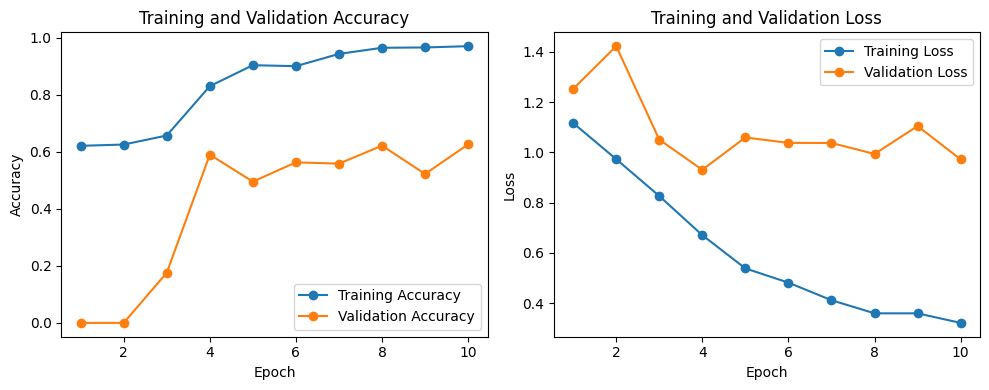

In [11]:
model_run(embedding_dim = 62, lstm_unit = 48, dropout_rate = 0.2, reg_strength = 0.3)